In [57]:
import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [58]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior() 
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt
import urllib.request, json
import os
import numpy as np

In [59]:
learning_rate = 0.0001
trainEpochs = 50
batchSize = 100
display = 1

hidden1 = 256
hidden2 = 128 
ninput = 784 
classes = 10 

In [60]:
X = tf.placeholder("float", [None, ninput])
Y = tf.placeholder("float", [None, classes])

weights = {
    'h1': tf.Variable(tf.random_normal([ninput, hidden1])),
    'h2': tf.Variable(tf.random_normal([hidden1, hidden2])),
    'out': tf.Variable(tf.random_normal([hidden2, classes]))
}
biases = {
    'b1': tf.Variable(tf.random_normal([hidden1])),
    'b2': tf.Variable(tf.random_normal([hidden2])),
    'out': tf.Variable(tf.random_normal([classes]))
}

In [61]:
def multilayer_perceptron(x):
    layer1 = tf.add(tf.matmul(x, weights['h1']), biases['b1'])
    layer1 = tf.nn.relu(layer1, name ='ReLU') 
    layer2 = tf.add(tf.matmul(layer1, weights['h2']), biases['b2'])
    layer2 = tf.nn.relu(layer2, name ='ReLU') 
    outlayer = tf.matmul(layer2, weights['out']) + biases['out']
    return outlayer

In [62]:
with tf.name_scope('Model'):
    p = multilayer_perceptron(X)

with tf.name_scope('loss'):
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=p, labels=Y))
    
with tf.name_scope('SGD'):
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss)

    
with tf.name_scope('Accuracy'):
    accuracy = tf.equal(tf.argmax(p, 1), tf.argmax(Y, 1))
    accuracy = tf.reduce_mean(tf.cast(accuracy, "float"))

In [63]:
i = tf.global_variables_initializer()

tsl = tf.summary.scalar("training_loss", loss)
vsl = tf.summary.scalar("validation_loss", loss)

ts = tf.summary.scalar("training_accuracy", accuracy)
vs = tf.summary.scalar("validation_accuracy", accuracy)

pst = tf.summary.merge([tsl,ts])
psv = tf.summary.merge([vsl,vs])

In [64]:
if not os.path.exists('summaries'):
    os.mkdir('summaries')
if not os.path.exists(os.path.join('summaries','first')):
    os.mkdir(os.path.join('summaries','first'))

config = tf.ConfigProto(allow_soft_placement=True)
config.gpu_options.allow_growth = True
config.gpu_options.per_process_gpu_memory_fraction = 0.9

session = tf.InteractiveSession(config=config)

In [65]:
with tf.Session() as sess:
    
    sess.run(i)
    
    s = tf.summary.FileWriter(os.path.join('summaries','first'), graph=session.graph)
    avgcostr_ls = []
    avgcostr_test_ls = []
    for epoch in range(trainEpochs):
        avgcost = 0.
        avgcost_test = 0.
        totalbatch = int(mnist.train.num_examples/batchSize)
        totalbatch_test= int(mnist.test.num_examples/batchSize)
        ls = []
        for i in range(totalbatch):
            batchx, batchy = mnist.train.next_batch(batchSize)  
            batchx_test, batchy_test = mnist.test.next_batch(batchSize)
            _, c, summary = sess.run([optimizer, loss, pst],
                                     feed_dict={X: batchx,Y: batchy})
            _, c_test, summary_test = sess.run([optimizer, loss, pst],
                                     feed_dict={X: batchx_test,Y: batchy_test})
               
            s.add_summary(summary, epoch * totalbatch + i)
            
            avgcost_test += c_test/totalbatch
            avgcost += c / totalbatch_test
            avgcostr_ls.append(avgcost)
            avgcostr_test_ls.append(avgcost_test)
            
        
        
        for i in range(totalbatch):
            batchx, batchy = mnist.validation.next_batch(batchSize)

            sval = sess.run(psv,feed_dict={X: batchx,Y: batchy})
            s.add_summary(sval, epoch * totalbatch + i)

        if epoch % display == 0:
            print("Epoch:", '%04d' % (epoch+1), "cost={:.3f}".format(avgcost),
                 "Training Accuracy:", accuracy.eval({X: mnist.train.images, Y: mnist.train.labels}),
                 "validation Accuracy:", accuracy.eval({X: mnist.validation.images, Y: mnist.validation.labels}))
            ls.append(avgcost)
    print("Optimization Finished!")
    
    print("Accuracy:", accuracy.eval({X: mnist.test.images, Y: mnist.test.labels}))

Epoch: 0001 cost=1797.286 Training Accuracy: 0.6082909 validation Accuracy: 0.619
Epoch: 0002 cost=514.653 Training Accuracy: 0.7439091 validation Accuracy: 0.7582
Epoch: 0003 cost=331.244 Training Accuracy: 0.7975636 validation Accuracy: 0.8098
Epoch: 0004 cost=252.548 Training Accuracy: 0.82887274 validation Accuracy: 0.8392
Epoch: 0005 cost=205.737 Training Accuracy: 0.84925455 validation Accuracy: 0.8516
Epoch: 0006 cost=174.279 Training Accuracy: 0.86367273 validation Accuracy: 0.8658
Epoch: 0007 cost=151.592 Training Accuracy: 0.87412727 validation Accuracy: 0.8778
Epoch: 0008 cost=134.173 Training Accuracy: 0.8832545 validation Accuracy: 0.8856
Epoch: 0009 cost=120.494 Training Accuracy: 0.8897273 validation Accuracy: 0.8926
Epoch: 0010 cost=109.397 Training Accuracy: 0.8961818 validation Accuracy: 0.8974
Epoch: 0011 cost=100.036 Training Accuracy: 0.9015273 validation Accuracy: 0.8998
Epoch: 0012 cost=92.009 Training Accuracy: 0.9066182 validation Accuracy: 0.9024
Epoch: 0013 c

27500
27500


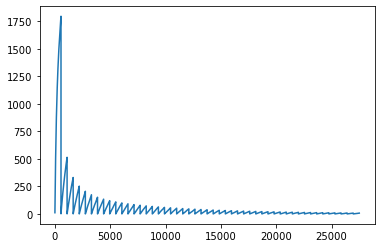

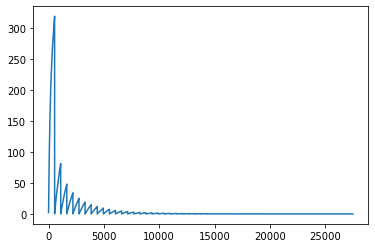

In [68]:
plt.plot(avgcostr_ls) #training loss vs. training iterations
plt.show()
plt.plot(avgcostr_test_ls) #test loss vs. training iterations.
plt.show()

